In [4]:
import os 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [5]:
device = torch.device("cuda")
device

device(type='cuda')

### Load Data

In [6]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, .224, 0.225])
])

In [7]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root = dataset_path, transform = image_transforms)
len(dataset)

2300

In [34]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [32]:
num_classes = len(dataset.classes)
num_classes

6

In [10]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [11]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [12]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)

In [13]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [14]:
labels[0]

tensor(2)

In [15]:
images[0].shape

torch.Size([3, 224, 224])

In [16]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].


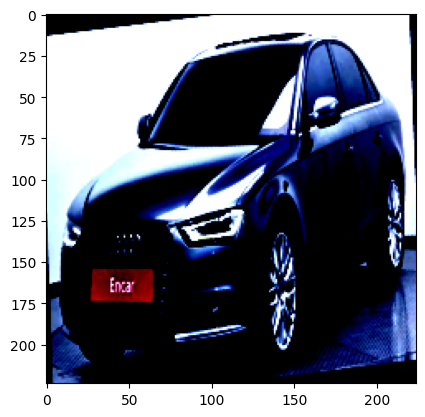

In [17]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

### Model 1: CNN

In [18]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)  
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [19]:
model = CarClassifierCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [20]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [21]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.79
Batch: 20, Epoch: 1, Loss: 1.77
Batch: 30, Epoch: 1, Loss: 1.71
Batch: 40, Epoch: 1, Loss: 1.47
Batch: 50, Epoch: 1, Loss: 1.36
Epoch [1/10], Avg Loss: 1.7866
*** Validation Accuracy: 40.52% ***
Batch: 10, Epoch: 2, Loss: 1.29
Batch: 20, Epoch: 2, Loss: 1.01
Batch: 30, Epoch: 2, Loss: 1.29
Batch: 40, Epoch: 2, Loss: 1.39
Batch: 50, Epoch: 2, Loss: 1.16
Epoch [2/10], Avg Loss: 1.2873
*** Validation Accuracy: 45.22% ***
Batch: 10, Epoch: 3, Loss: 1.03
Batch: 20, Epoch: 3, Loss: 1.08
Batch: 30, Epoch: 3, Loss: 0.98
Batch: 40, Epoch: 3, Loss: 1.12
Batch: 50, Epoch: 3, Loss: 1.40
Epoch [3/10], Avg Loss: 1.1795
*** Validation Accuracy: 48.00% ***
Batch: 10, Epoch: 4, Loss: 1.18
Batch: 20, Epoch: 4, Loss: 1.19
Batch: 30, Epoch: 4, Loss: 0.92
Batch: 40, Epoch: 4, Loss: 0.90
Batch: 50, Epoch: 4, Loss: 1.26
Epoch [4/10], Avg Loss: 1.1227
*** Validation Accuracy: 47.83% ***
Batch: 10, Epoch: 5, Loss: 1.04
Batch: 20, Epoch: 5, Loss: 1.29
Batch: 30, Epoch: 5, Loss: 1

### Model 2: CNN with Regularization

In [22]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [23]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 9.81
Batch: 20, Epoch: 1, Loss: 8.57
Batch: 30, Epoch: 1, Loss: 2.38
Batch: 40, Epoch: 1, Loss: 1.95
Batch: 50, Epoch: 1, Loss: 1.61
Epoch [1/10], Avg Loss: 8.5037
*** Validation Accuracy: 25.39% ***
Batch: 10, Epoch: 2, Loss: 1.74
Batch: 20, Epoch: 2, Loss: 1.53
Batch: 30, Epoch: 2, Loss: 1.53
Batch: 40, Epoch: 2, Loss: 1.63
Batch: 50, Epoch: 2, Loss: 1.49
Epoch [2/10], Avg Loss: 1.5743
*** Validation Accuracy: 37.74% ***
Batch: 10, Epoch: 3, Loss: 1.35
Batch: 20, Epoch: 3, Loss: 1.34
Batch: 30, Epoch: 3, Loss: 1.46
Batch: 40, Epoch: 3, Loss: 1.58
Batch: 50, Epoch: 3, Loss: 1.47
Epoch [3/10], Avg Loss: 1.4801
*** Validation Accuracy: 42.78% ***
Batch: 10, Epoch: 4, Loss: 1.47
Batch: 20, Epoch: 4, Loss: 1.52
Batch: 30, Epoch: 4, Loss: 1.43
Batch: 40, Epoch: 4, Loss: 1.53
Batch: 50, Epoch: 4, Loss: 1.40
Epoch [4/10], Avg Loss: 1.4469
*** Validation Accuracy: 46.61% ***
Batch: 10, Epoch: 5, Loss: 1.45
Batch: 20, Epoch: 5, Loss: 1.24
Batch: 30, Epoch: 5, Loss: 1

### Model 3: Transfer Learning with EfficientNet

In [24]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\kesav/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:16<00:00, 1.29MB/s]


1280

In [25]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [26]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.71
Batch: 20, Epoch: 1, Loss: 1.40
Batch: 30, Epoch: 1, Loss: 1.37
Batch: 40, Epoch: 1, Loss: 1.28
Batch: 50, Epoch: 1, Loss: 1.21
Epoch [1/10], Avg Loss: 1.4697
*** Validation Accuracy: 55.65% ***
Batch: 10, Epoch: 2, Loss: 1.25
Batch: 20, Epoch: 2, Loss: 1.19
Batch: 30, Epoch: 2, Loss: 0.95
Batch: 40, Epoch: 2, Loss: 0.77
Batch: 50, Epoch: 2, Loss: 0.98
Epoch [2/10], Avg Loss: 1.1226
*** Validation Accuracy: 59.30% ***
Batch: 10, Epoch: 3, Loss: 1.10
Batch: 20, Epoch: 3, Loss: 1.01
Batch: 30, Epoch: 3, Loss: 0.85
Batch: 40, Epoch: 3, Loss: 1.29
Batch: 50, Epoch: 3, Loss: 1.04
Epoch [3/10], Avg Loss: 0.9941
*** Validation Accuracy: 59.13% ***
Batch: 10, Epoch: 4, Loss: 0.90
Batch: 20, Epoch: 4, Loss: 0.77
Batch: 30, Epoch: 4, Loss: 0.97
Batch: 40, Epoch: 4, Loss: 0.77
Batch: 50, Epoch: 4, Loss: 0.90
Epoch [4/10], Avg Loss: 0.9364
*** Validation Accuracy: 63.48% ***
Batch: 10, Epoch: 5, Loss: 0.93
Batch: 20, Epoch: 5, Loss: 0.94
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [27]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [28]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\kesav/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:15<00:00, 1.36MB/s]


Batch: 10, Epoch: 1, Loss: 1.34
Batch: 20, Epoch: 1, Loss: 0.90
Batch: 30, Epoch: 1, Loss: 0.76
Batch: 40, Epoch: 1, Loss: 0.63
Batch: 50, Epoch: 1, Loss: 0.67
Epoch [1/10], Avg Loss: 0.8840
*** Validation Accuracy: 72.87% ***
Batch: 10, Epoch: 2, Loss: 0.51
Batch: 20, Epoch: 2, Loss: 0.37
Batch: 30, Epoch: 2, Loss: 0.54
Batch: 40, Epoch: 2, Loss: 0.49
Batch: 50, Epoch: 2, Loss: 0.53
Epoch [2/10], Avg Loss: 0.4851
*** Validation Accuracy: 73.22% ***
Batch: 10, Epoch: 3, Loss: 0.14
Batch: 20, Epoch: 3, Loss: 0.40
Batch: 30, Epoch: 3, Loss: 0.15
Batch: 40, Epoch: 3, Loss: 0.30
Batch: 50, Epoch: 3, Loss: 0.36
Epoch [3/10], Avg Loss: 0.3530
*** Validation Accuracy: 76.35% ***
Batch: 10, Epoch: 4, Loss: 0.37
Batch: 20, Epoch: 4, Loss: 0.47
Batch: 30, Epoch: 4, Loss: 0.24
Batch: 40, Epoch: 4, Loss: 0.25
Batch: 50, Epoch: 4, Loss: 0.16
Epoch [4/10], Avg Loss: 0.2467
*** Validation Accuracy: 79.65% ***
Batch: 10, Epoch: 5, Loss: 0.20
Batch: 20, Epoch: 5, Loss: 0.17
Batch: 30, Epoch: 5, Loss: 0

best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

In [29]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.85
Batch: 20, Epoch: 1, Loss: 0.96
Batch: 30, Epoch: 1, Loss: 0.77
Batch: 40, Epoch: 1, Loss: 0.70
Batch: 50, Epoch: 1, Loss: 0.94
Epoch [1/10], Avg Loss: 0.8790
*** Validation Accuracy: 65.22% ***
Batch: 10, Epoch: 2, Loss: 0.72
Batch: 20, Epoch: 2, Loss: 0.53
Batch: 30, Epoch: 2, Loss: 0.35
Batch: 40, Epoch: 2, Loss: 0.35
Batch: 50, Epoch: 2, Loss: 0.42
Epoch [2/10], Avg Loss: 0.5103
*** Validation Accuracy: 73.57% ***
Batch: 10, Epoch: 3, Loss: 0.59
Batch: 20, Epoch: 3, Loss: 0.27
Batch: 30, Epoch: 3, Loss: 0.20
Batch: 40, Epoch: 3, Loss: 0.25
Batch: 50, Epoch: 3, Loss: 0.35
Epoch [3/10], Avg Loss: 0.3564
*** Validation Accuracy: 74.26% ***
Batch: 10, Epoch: 4, Loss: 0.13
Batch: 20, Epoch: 4, Loss: 0.13
Batch: 30, Epoch: 4, Loss: 0.22
Batch: 40, Epoch: 4, Loss: 0.12
Batch: 50, Epoch: 4, Loss: 0.21
Epoch [4/10], Avg Loss: 0.2550
*** Validation Accuracy: 74.78% ***
Batch: 10, Epoch: 5, Loss: 0.22
Batch: 20, Epoch: 5, Loss: 0.10
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report

In [30]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       123
           1       0.69      0.72      0.71        98
           2       0.89      0.86      0.88       124
           3       0.83      0.62      0.71        73
           4       0.59      0.67      0.62        72
           5       0.73      0.78      0.75        85

    accuracy                           0.76       575
   macro avg       0.76      0.75      0.75       575
weighted avg       0.77      0.76      0.76       575



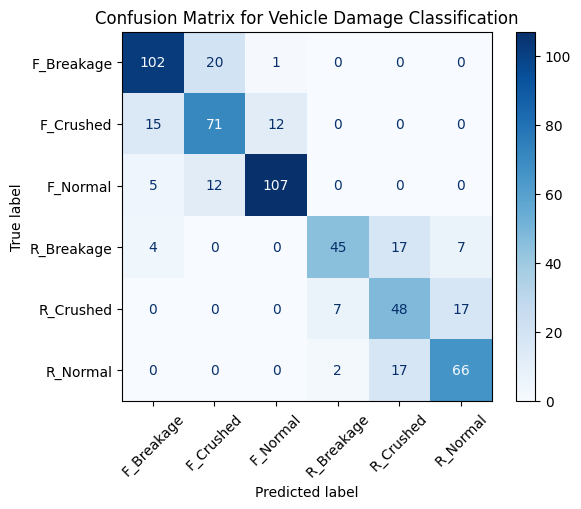

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [36]:
torch.save(model.state_dict(), 'saved_model.pth')